In [47]:
#!pip install numpy==1.25.2 scipy==1.11.2 matplotlib==3.7.2 sympy==1.12

In [48]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.pyplot as plt

1. Начальные данные

In [49]:
np.random.seed(seed=1)
n = 40
sigma = 1.7**0.5
theta = np.array([-12, 6, -2, -0.15])
norm_eps = np.random.normal(0, sigma, n)
unif_eps = np.random.uniform(-np.sqrt(3)*sigma, np.sqrt(3)*sigma, n)
cases = {"N": {"eps": norm_eps, "theta": theta}, "U": {"eps":unif_eps, "theta": theta[:-1]}}
B = 6
x = -4 + np.arange(1,n+1)*8/n

Функции этапов анализа

In [50]:
x2matrix = lambda x, m: np.array([[xx**i for i in range(m+1)] for xx in x])
sig2str = lambda coef: " + ".join([f"({cs})x^{i}" if i > 0 else cs for i, c in enumerate(coef) if (cs := str(round(c,3)))])

def y_nab(theta, x, eps=0):
    return x2matrix(x,theta.shape[0]-1) @ theta + eps

def mnk(x_test, y_test, m=1):
    """Метод наименьших квадратов"""
    X = x2matrix(x_test, m)
    coef = np.linalg.inv(X.T @ X) @ (X.T @ y_test)
    return coef, X

def fisher(X, y, coef):
    """Статистика Фишера (вычисление)"""
    p = coef.shape[0]
    r_m = np.diag(np.linalg.inv(X.T @ X))[-1]
    return ((n-p) * coef[-1]**2) / ((r_m) * np.linalg.norm(y - X @ coef)**2)

def fisher_iter(x, y, a=0.05):
    """Вычисление оптимальной степени аппроксимации"""
    for m in range(1, 10+1):
        coef, X = mnk(x, y, m)
        f_a = fisher(X, y, coef)
        f_t = sp.stats.f.ppf(1-a, 1, n - coef.shape[0]) # Квантиль 1-a распределения Фишера
        print(f"Статистика Фишера при {m=} для измер.: {f_a} и теор: {f_t}")
        if np.abs(f_a) < f_t:
            break
    return *mnk(x,y,m-1), (f_a, f_t)

def interval_coef(x, y, coef, X, a=0.05):
    """Вычисление доверительного интервала параметров"""
    t = sp.stats.t.ppf(1-a/2, x.shape[0] - coef.shape[0]) # Квантиль 1-a/2 распределения Стьюдента
    E = np.linalg.norm(y - X @ coef)
    alpha = np.diag(np.linalg.inv(X.T @ X))
    delta = t*E*np.sqrt(alpha/(n-coef.shape[0]))
    return coef - delta, coef + delta, delta

def graph_apr_data(x, y_p, y_s, y_apr):
    """Построение графика набора наблюдений полезного сигнала и его оценки"""
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(x, y_p, color="g", label="Полезный сигнал")
    plt.plot(x, y_s, color="r", marker="o", alpha=0.5, label="Наблюдения")
    plt.plot(x, y_apr, color="b", label="Оценка сигнала")
    plt.legend()

def graph_interval(x, y, X, coef):
    """Построение графика с доверительными интервалами полезного сигнала"""
    p = coef.shape[0]
    t95 = sp.stats.t.ppf(1-0.05/2, x.shape[0] - p)
    t99 = sp.stats.t.ppf(1-0.01/2, x.shape[0] - p)
    
    E = y - X @ coef
    x_s = sym.Symbol("x")
    r_x = sym.Matrix([x_s**i for i in range(len(coef))])
    
    r = sym.simplify(sym.sqrt(r_x.T * sym.Matrix(np.linalg.inv(X.T @ X)) * r_x)[0,0] / np.sqrt(n-p))
    delta_f95 = sym.simplify(t95*np.linalg.norm(E)* r)
    delta_f99 = sym.simplify(t99*np.linalg.norm(E)* r)
    print("Delta_0.95:")
    sym.print_latex(delta_f95)
    print("Delta_0.99:")
    sym.print_latex(delta_f99)
    dfu95 = sym.lambdify("x", delta_f95, modules="numpy")
    dfu99 = sym.lambdify("x", delta_f99, modules="numpy")
    
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")
    y_r = X @ coef
    plt.plot(x, y_r, label="Полезный сигнал", c="r")
    plt.fill_between(x, y_r - dfu99(x), y_r + dfu99(x), color="yellow", alpha=0.5, label=r"Уровень $\alpha$=" + f"0.99")
    plt.fill_between(x, y_r - dfu95(x), y_r + dfu95(x), color="blue", alpha=0.5, label=r"Уровень $\alpha$=" + f"0.95")
    plt.legend()

def get_params(e, b=6):
    """Получение параметров выборки"""
    n = e.shape[0]
    n_freq, bins = np.histogram(e, bins=B)
    x_i_m = np.array([(bins[i-1] + bins[i])/2 for i in range(bins.shape[0]) if i> 0])
    x_w = np.sum(x_i_m*n_freq)/n
    s = np.sqrt(np.sum(n_freq*(x_i_m - x_w)**2)/(n-1))
    return (n_freq, bins, x_i_m), x_w, s

def graph_hist(y, X, coef, b = 6):
    """Построение гистограммы по остаткам регрессии"""
    e = y - X @ coef
    n = y.shape[0]
    (his, bins,_), mu, s = get_params(e, b)
    print(f"Гистограмма: {his} на {np.round(bins,3)}")
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('$\overline{h}(x)$')
    plt.hist(e, bins=b, density=True, edgecolor="k")
    plt.plot(np.sort(e), sp.stats.norm.pdf(np.sort(e), mu, s), label="Функция плотности распределения")
    plt.legend()
    plt.show()

def pirson(e, B, a=0.05):
    """Критерий Пирсона"""
    n = e.shape[0]
    (n_freq, bins, x_i_m), *_ = get_params(e, B)
    norm_p = sp.stats.norm(loc=0, scale=np.linalg.norm(e)/np.sqrt(n)) #нормальное распределение с заданными параметрами
    p = np.array([norm_p.cdf(bins[i]) - norm_p.cdf(bins[i-1]) for i in range(bins.shape[0]) if i > 0])
    K = np.sum((n_freq - n*p)**2 / (n*p))
    K_cr = sp.stats.chi2.ppf(1-a, B - 1 - 1)
    return K, K_cr

Момент вариации: при выборе N - первый случай, при выборе U - второй

In [51]:
case = "N"
np.round(cases[case]["eps"], 3)

array([ 2.118, -0.798, -0.689, -1.399,  1.128, -3.001,  2.275, -0.992,
        0.416, -0.325,  1.906, -2.686, -0.42 , -0.501,  1.478, -1.434,
       -0.225, -1.145,  0.055,  0.76 , -1.435,  1.493,  1.176,  0.655,
        1.175, -0.891, -0.16 , -1.22 , -0.349,  0.691, -0.902, -0.517,
       -0.896, -1.102, -0.875, -0.017, -1.457,  0.306,  2.164,  0.968])

2. Критерий Фишера

In [52]:
y = y_nab(cases[case]["theta"], x, cases[case]["eps"])
coef, X, _ = fisher_iter(x, y)
coef

Статистика Фишера при m=1 для измер.: 36.61460071355997 и теор: 4.098171730880841
Статистика Фишера при m=2 для измер.: 1005.482838728312 и теор: 4.105455897235966
Статистика Фишера при m=3 для измер.: 42.6834772003802 и теор: 4.1131652768128895
Статистика Фишера при m=4 для измер.: 4.451841589243568 и теор: 4.1213382003449
Статистика Фишера при m=5 для измер.: 0.3565203306216016 и теор: 4.130017745652016


array([-11.75782985,   5.98464559,  -2.27617514,  -0.14997824,
         0.02173143])

3. Доверительные интервалы для параметров

In [53]:
coefd1 = interval_coef(x, y, coef, X, 0.05)
coefd2 = interval_coef(x, y, coef, X, 0.01)
print(f"Доверительные интервалы для параметров a=0.95: min: {coefd1[0]} \t max: {coefd1[1]}")
print(f"Доверительные интервалы для параметров a=0.99: min: {coefd2[0]} \t max: {coefd2[1]}")

Доверительные интервалы для параметров a=0.95: min: [-1.25155072e+01  5.54330747e+00 -2.57353228e+00 -1.92741827e-01
  8.22222174e-04] 	 max: [-11.00015251   6.42598371  -1.97881799  -0.10721465   0.04264064]
Доверительные интервалы для параметров a=0.99: min: [-1.27744092e+01  5.39250011e+00 -2.67514065e+00 -2.07354351e-01
 -6.32255580e-03] 	 max: [-10.74125051   6.57679107  -1.87720962  -0.09260212   0.04978542]


4. Доверительные интервалы для сигнала, графики, гистограмма и оценка дисперсии

In [54]:
coef_s = cases[case]["theta"]
X_s = x2matrix(x,m=coef_s.shape[0]-1)

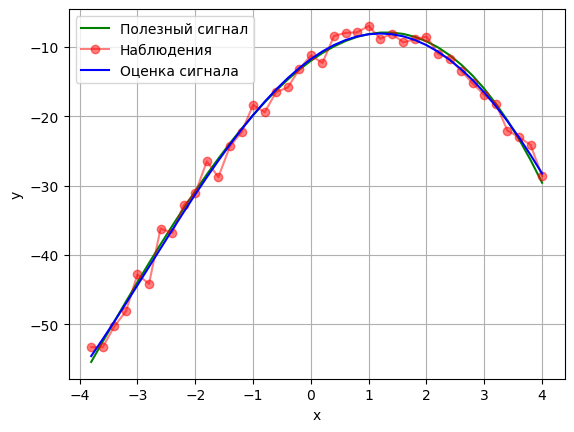

In [55]:
graph_apr_data(x, X_s @ coef_s, y, X @ coef)

Delta_0.95:
0.75767734234676 \sqrt{0.000761564460051842 x^{8} - 0.000609251568041471 x^{7} - 0.0175551487534236 x^{6} + 0.0106183844715799 x^{5} + 0.126811884306548 x^{4} - 0.051433783290318 x^{3} - 0.245260283379278 x^{2} + 0.0500835704095371 x + 1}
Delta_0.99:
1.01657934102009 \sqrt{0.000761564460051842 x^{8} - 0.000609251568041471 x^{7} - 0.0175551487534236 x^{6} + 0.0106183844715799 x^{5} + 0.126811884306548 x^{4} - 0.051433783290318 x^{3} - 0.245260283379278 x^{2} + 0.0500835704095371 x + 1}


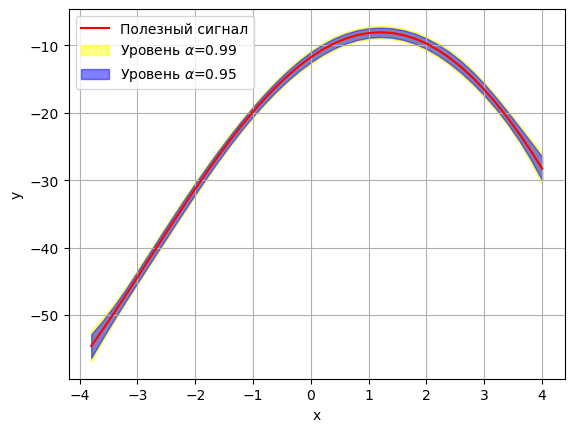

In [56]:
graph_interval(x, y, X, coef)

Гистограмма: [ 3  8 15  5  7  2] на [-2.456 -1.569 -0.682  0.206  1.093  1.98   2.867]


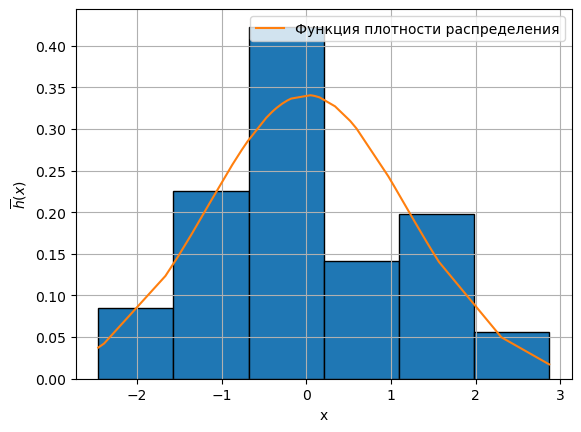

In [57]:
graph_hist(y, X, coef, B)

In [58]:
sigma_err = np.linalg.norm(y - X @ coef)**2/ n
sigma_err

1.386159298022012

5. Критерий Пирсона

In [59]:
pirson(y - X @ coef, B, 0.05)

(4.43593106679982, 9.487729036781154)